In [1]:
'''
Training:
	For each training video:
		-construct a sequence of 1D-distance signals from person centroids

	Perform PCA on the sequence to reduce dimensionality

Test Pre-process:
	Given a training sequence
		-construct the sequence of 1D-distance signals
		-project onto eigenspace found in training process

Classification:
	Perform KNN, SVM, or any other classification algorithm we would like to try
'''
import os
import numpy as np
import cv2
from numpy import linalg as LA
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

def denoiseSilhouette(img):
	'''
	Denoise the image silhouettes to give a more rounded shape. Use this
	when using real world images as background model will not be given
	and silhouettes will likely be noisier than training data.
	'''
	kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
	erosion = cv2.erode(img,kernel,iterations = 2)
	dilation = cv2.dilate(erosion,kernel,iterations = 3)
	closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

	return closing

def findMaxContour(img):
	'''
	Find the largest contour in the image which should be the outline
	of the person.
	'''
	img2, contour,hier = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
	areas = [cv2.contourArea(c) for c in contour]
	cnt=contour[np.argmax(areas)]

	M = cv2.moments(cnt)
	cx = int(M['m10']/M['m00'])
	cy = int(M['m01']/M['m00'])
	return cx, cy, cnt

def toDistSeq(img_path):
	'''
	Given the path to a folder of images representing frames of a video,
	turn each frame into a 1D distance signal and concatenate into an
	image.
	'''
	img = cv2.imread(img_path,0)
	denoised = denoiseSilhouette(img)
	cx, cy, cnt = findMaxContour(denoised)
	dists = np.zeros(len(cnt))

	#Find distance betweem center to all contour poiints
	for i in xrange(len(cnt)):
		x = cnt[i][0][0]
		y = cnt[i][0][1]
		dists[i] = np.sqrt(((x-cx)**2)+((y-cy)**2))

	#L1 normalization of distances
	dists_norm = dists / LA.norm(dists,1)

	#Subsample the vector to a constant size
	indices = np.linspace(0,len(dists_norm),360,endpoint=False,dtype=np.int32)
	sampled_dists = dists_norm[indices]
	return sampled_dists

def loadData(datapath,dataset):
	'''
	MOBO path form:
	/data/moboBgSub/userID/mode/vidID/orientation/frame.pbm

	CASIA path form:
	/DatasetB/silhouettes/subjectID/walkingStatus-seqNum/viewAngle

	CASIA has more data to train on so it's reccomended to use that dataset when training
	'''
	N = 100   #The number of frames from each sequence to use
	if(dataset=="MOBO"):
		orientation_map = {'vr03_7':0,'vr05_7':1,'vr07_7':2,
						   'vr13_7':3,'vr16_7':4,'vr17_7':5,}
		X = np.zeros((6,100*25,360))
		y = np.zeros((6,100*25))
		topLevel = datapath+"/moboBgSub/"
		indices = [0,0,0,0,0,0]
		for userID in sorted(next(os.walk(topLevel))[1]):
			mode = "slowWalk"
			for orientation in sorted(next(os.walk(topLevel+userID+"/"+"slowWalk"))[1]):
				n = 0
				clf_index = orientation_map[orientation]
				for img in sorted(next(os.walk(topLevel+userID+"/"+mode+"/"+orientation))[2]):
					if(n >= N):
						break
					img_path = topLevel+userID+"/"+mode+"/"+orientation+"/"+img
					distSignal = toDistSeq(img_path)
					X[clf_index,indices[clf_index],:] = distSignal
					y[clf_index,indices[clf_index]] = userID
					indices[clf_index] += 1
					n += 1
		return X, y

	elif(dataset=="CASIA"):
		topLevel = datapath+"/silhouettes/"
		for subID in next(os.walk(topLevel))[1]:
			for seqNum in next(os.walk(topLevel+subID))[1]:
				for viewAngle in next(os.walk(topLevel+subID+"/"+seqNum))[1]:
					for img in next(os.walk(topLevel+subID+"/"+seqNum+"/"+viewAngle))[2]:
						img_path = topLevel+subID+"/"+seqNum+"/"+viewAngle+"/"+img
						distSignal = toDistSeq(img_path)
	else:
		print "Invalid dataset input"
		return 0

# Load the Data

In [2]:
#Load data and encode labels
X, y = loadData('data','MOBO')
le = preprocessing.LabelEncoder()
le.fit(np.unique(y))
y = le.transform(y)

## Split Data into Train and Test Set

In [3]:
X = X[0,:,:]
y = y[0,:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

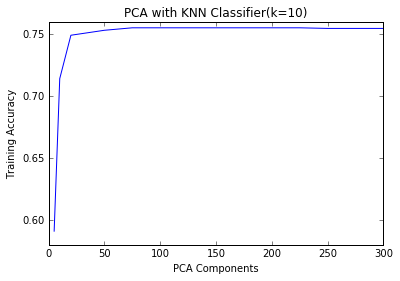

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

component_grid = [5,10,20,50,75,100,125,150,175,200,225,250,275,300]

scores = []
for num_components in component_grid:
	#Perform PCA on data
	pca = PCA(n_components=num_components)
	pca.fit(X_train)

	#Traing KNN classifier
	neigh = KNeighborsClassifier(n_neighbors=10)
	neigh.fit(pca.transform(X_train),y_train)

	#Test the classifier
	reduced = pca.transform(X_train)
	score =  neigh.score(reduced,y_train)
	scores.append(score)

plt.plot(component_grid,scores)
plt.xlabel('PCA Components')
plt.ylabel('Training Accuracy')
plt.title('PCA with KNN Classifier(k=10)')

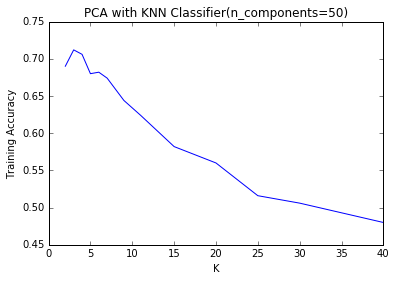

In [31]:
neighbor_grid = [2,3,4,5,6,7,9,11,15,20,25,30,40]
pca = PCA(n_components=50)
pca.fit(X_train)

scores = []
for neighbors in neighbor_grid: 
    clf = KNeighborsClassifier(n_neighbors=neighbors)
    clf.fit(pca.transform(X_train),y_train)
    
    reduced = pca.transform(X_test)
    score = clf.score(reduced,y_test)
    scores.append(score)
    
plt.plot(neighbor_grid,scores)
plt.xlabel('K')
plt.ylabel('Training Accuracy')
plt.title('PCA with KNN Classifier(n_components=50)')

## GridSearch for Best KNN Classifier

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

component_grid = [5,10,20,50,75,100,125,150,175,200,225,250,275,300]
neighbor_grid = [2,3,4,5,6,7,9,11,15,20,25,30,40]

estimators = [('reduce_dim', PCA()), ('knn', KNeighborsClassifier())]
clf = Pipeline(estimators)

params = {'reduce_dim__n_components':neighbor_grid,
          'knn__n_neighbors':component_grid}

grid_search = GridSearchCV(clf,param_grid=params)
grid_search.fit(X_train,y_train)

print grid_search.score(X_test,y_test)

0.684


## GridSearch for Best SVM Classifier

In [21]:
from sklearn import svm

component_grid = [5,10,20,50,75,100,125,150,175,200,225,250,275,300]

estimators = [('reduce_dim', PCA()), ('svm', svm.SVC())]
clf = Pipeline(estimators)

params = {'reduce_dim__n_components':neighbor_grid,
          'svm__kernel':('linear', 'rbf'),
          'svm__C':[1,3,5,7,10,15]}

grid_search = GridSearchCV(clf,param_grid=params)
grid_search.fit(X_train,y_train)

print grid_search.score(X_test,y_test)

0.022


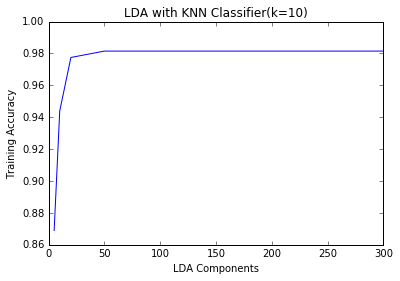

In [33]:
from sklearn.lda import LDA

component_grid = [5,10,20,50,75,100,125,150,175,200,225,250,275,300]

scores = []
for num_components in component_grid:
	#Perform PCA on data
	pca = LDA(n_components=num_components)
	pca.fit(X_train,y_train)

	#Traing KNN classifier
	neigh = KNeighborsClassifier(n_neighbors=10)
	neigh.fit(pca.transform(X_train),y_train)

	#Test the classifier
	reduced = pca.transform(X_train)
	score =  neigh.score(reduced,y_train)
	scores.append(score)

plt.plot(component_grid,scores)
plt.xlabel('LDA Components')
plt.ylabel('Training Accuracy')
plt.title('LDA with KNN Classifier(k=10)')

## GridSearch for Best KNN Classifier

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

component_grid = [5,10,20,50,75,100]
neighbor_grid = [2,3,4,5,6,7,9,11,15,20,25,30,40]

estimators = [('reduce_dim', LDA()), ('knn', KNeighborsClassifier())]
clf = Pipeline(estimators)

params = {'reduce_dim__n_components':neighbor_grid,
          'knn__n_neighbors':component_grid}

grid_search = GridSearchCV(clf,param_grid=params)
grid_search.fit(X_train,y_train)

print grid_search.score(X_test,y_test)

0.88


/usr/local/lib/python2.7/dist-packages/sklearn/discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


## GridSearch for Best SVM Classifier

In [27]:
from sklearn import svm

component_grid = [5,10,20,50,75,100]

estimators = [('reduce_dim', LDA()), ('svm', svm.SVC())]
clf = Pipeline(estimators)

params = {'reduce_dim__n_components':neighbor_grid,
          'svm__kernel':('linear', 'rbf'),
          'svm__C':[1,3,5,7,10,15]}

grid_search = GridSearchCV(clf,param_grid=params)
grid_search.fit(X_train,y_train)

print grid_search.score(X_test,y_test)

0.84
